# Naive Bayes

In [1]:
import pandas as pd
import numpy as np
import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

In [10]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16,Palermo,relacion_de_dependencia,27,universidad_2_anio,matrimonio_civil,0,mujer,38,cristianismo,casada,0,soporte_tecnico
32557,13,Palermo,relacion_de_dependencia,40,4_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,1,inspector
32558,13,Palermo,relacion_de_dependencia,58,4_anio,viudo_a,0,mujer,40,cristianismo,soltero_a,0,entretenimiento
32559,13,Palermo,relacion_de_dependencia,22,4_anio,sin_matrimonio,0,hombre,20,cristianismo,con_hijos,0,entretenimiento


### Llamado a funciones de preprocesamiento

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encodding(df)

### Separacion de datos de entrenamiento para los tres modelos a estudiar

In [4]:
# modelo 1
X_train, X_val, y_train, y_val = preprocessing.dataset_split(df)

# modelo 2 y 3
X_train_g = X_train[['ganancia_perdida_declarada_bolsa_argentina']]
X_val_g = X_val[['ganancia_perdida_declarada_bolsa_argentina']]

# modelo 3
X_train_m = X_train.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')
X_val_m = X_val.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

## Modelos

### Modelo 1
- se tratan todos los features como continuos

In [5]:
gnb = GaussianNB().fit(X_train, y_train)

y_pred = gnb.predict(X_val)
print(f"{np.sum(y_pred == y_val)} de {len(X_val)} predicciones correctas")

7633 de 9769 predicciones correctas


### Modelo 2
- se tratan todos los features como discretos 
- se descarta el feature ganancia_perdida_declarada_bolsa_argentina ya que toma demasiados valores y ademas tiene valores negativos que no son validos para el algoritmo

In [6]:
mnb = MultinomialNB().fit(X_train_m, y_train)

y_pred = mnb.predict(X_val_m)

print(f"{np.sum(y_pred == y_val)} de {len(X_val_m)} predicciones correctas")

7366 de 9769 predicciones correctas


### Modelo 3
- se usa una combinación de naive bayes multinomial y gaussiano

In [7]:
gnb = GaussianNB().fit(X_train_g, y_train)
mnb = MultinomialNB().fit(X_train_m, y_train)

X_train_proba_g = pd.DataFrame(gnb.predict_proba(X_train_g)).drop(0, axis='columns')
X_train_proba_m = pd.DataFrame(mnb.predict_proba(X_train_m)).drop(0, axis='columns')

# se construye el dataframe de probabilidades con los datos de entrenamiento
X_train_proba = pd.DataFrame()
X_train_proba['1_gaussian'] = X_train_proba_g[1]
X_train_proba['1_multinomial'] = X_train_proba_m[1]

# se aplica naive bayes gaussiano al dataframe de probabilidades
gnb_proba = GaussianNB().fit(X_train_proba, y_train)

# se aplica el modelo compuesto a los datos de validación y se obtiene la predicción
X_val_proba_g = pd.DataFrame(gnb.predict_proba(X_val_g)).drop(0, axis='columns')
X_val_proba_m = pd.DataFrame(mnb.predict_proba(X_val_m)).drop(0, axis='columns')
X_val_proba = pd.DataFrame()
X_val_proba['1_gaussian'] = X_val_proba_g[1]
X_val_proba['1_multinomial'] = X_val_proba_m[1]
y_pred = gnb_proba.predict(X_val_proba)

print(f"{np.sum(y_pred == y_val)} de {len(X_val_proba)} predicciones correctas")

7761 de 9769 predicciones correctas


In [18]:
import sklearn.metrics as metrics
metrics.accuracy_score(y_val, y_pred)

0.794451837444979

In [19]:
metrics.precision_score(y_val, y_pred)

0.7328947368421053

In [20]:
metrics.recall_score(y_val, y_pred, pos_label = 0)

0.9725934926420953

In [21]:
metrics.f1_score(y_val, y_pred)

0.3568225496476617

In [23]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      7407
           1       0.73      0.24      0.36      2362

    accuracy                           0.79      9769
   macro avg       0.77      0.60      0.62      9769
weighted avg       0.78      0.79      0.75      9769



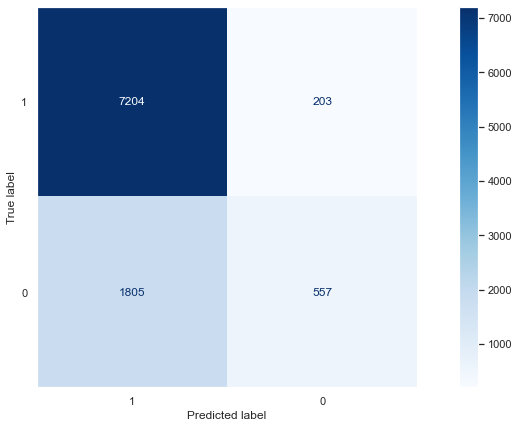

In [34]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
metrics.plot_confusion_matrix(gnb_proba, X_val_proba, y_val, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax)
plt.show()

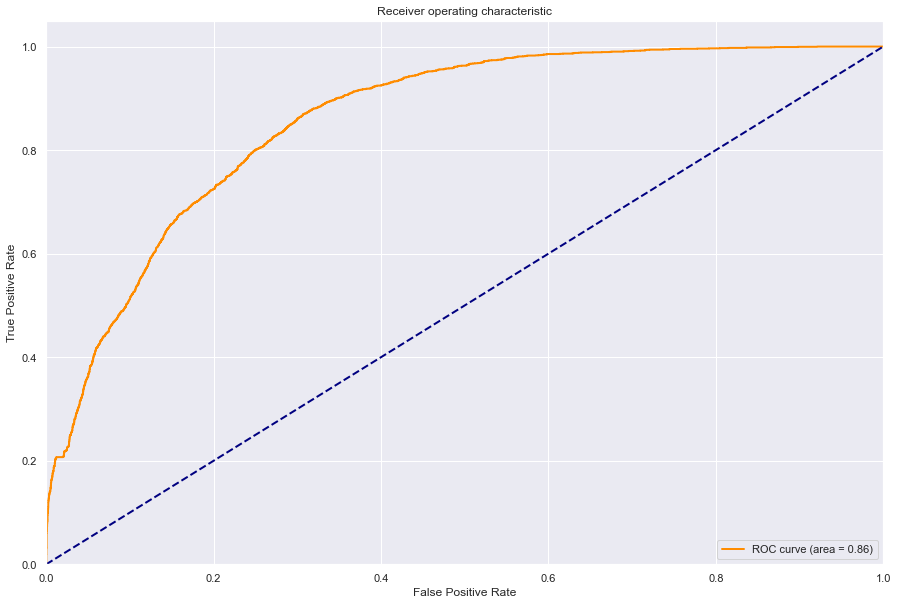

ROC AUC SCORE: 0.6042052983955607


In [51]:
def plot_roc(fpr, tpr, x):

    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
fpr, tpr, thresholds = metrics.roc_curve(y_val, gnb_proba.predict_proba(X_val_proba)[:,1]) # aca le paso las probabilidades en vez de y_pred, es lo mas recomendado
plot_roc(fpr, tpr, thresholds)
print(f"ROC AUC SCORE: {metrics.roc_auc_score(y_val, y_pred)}") # igual no hace falta esto porque se ve en el grafico (abajo a la derecha)